This notebook runs ECMWF's aifs-single-0.2.1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

# 1. Install Required Packages and Imports

In [1]:
# Uncomment the lines below to install the required packages

#!pip install -q anemoi-inference==0.3.3 anemoi-models==0.2.1
#!pip install -q earthkit-regrid==0.3.4 ecmwf-opendata huggingface_hub
#!pip install -q flash_attn

In [3]:
import datetime
import earthkit.data as ekd
import earthkit.regrid as ekr
import numpy as np
from collections import defaultdict
from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state
from ecmwf.opendata import Client as OpendataClient
from huggingface_hub import hf_hub_download

# 2. Retrieve Initial Conditions from ECMWF Open Data




### List of parameters to retrieve form ECMWF open data

In [4]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]

### Select a date

In [5]:
DATE = OpendataClient().latest()

In [6]:
print("Initial date is", DATE)

Initial date is 2024-12-05 18:00:00


### Get the data from the ECMWF Open Data API

In [7]:
def get_open_data(param, levelist=[]):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

### Get Input Fields

In [8]:
fields = {}

#### Add the single levels fields

In [9]:
fields.update(get_open_data(param=PARAM_SFC))

#### Add the pressure levels fields

In [10]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS))

#### Convert geopotential height into geopotential

In [11]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

### Create Initial State

In [12]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

### Download the Model's Checkpoint from Hugging Face

In [13]:
checkpoint = hf_hub_download("ecmwf/aifs-single", "aifs_single_v0.2.1.ckpt")

#### Create a Runner

In [14]:
runner = SimpleRunner(checkpoint, device="cuda")

#### Run the forecast

In [15]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)


😀 date=2024-12-06T00:00:00 latitudes=(542080,) longitudes=(542080,) fields=88

    q_50   shape=(542080,) min=1.84903e-06    max=3.27183e-06   
    t_700  shape=(542080,) min=230.54         max=294.216       
    v_300  shape=(542080,) min=-61.2203       max=74.7568       
    z_100  shape=(542080,) min=147618         max=164196        
    tp     shape=(542080,) min=0              max=0.0758046     


😀 date=2024-12-06T06:00:00 latitudes=(542080,) longitudes=(542080,) fields=88

    q_50   shape=(542080,) min=1.80871e-06    max=3.24624e-06   
    t_700  shape=(542080,) min=230.665        max=289.259       
    v_300  shape=(542080,) min=-56.8823       max=64.5709       
    z_100  shape=(542080,) min=147671         max=164199        
    tp     shape=(542080,) min=0              max=0.1131        



# 4. Inspect the generated forecast

#### Plot a field

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

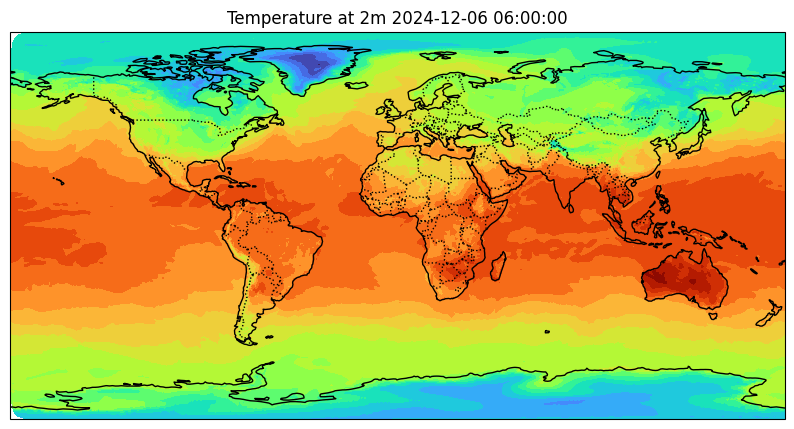

In [17]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["2t"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)
ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="turbo")
plt.title("Temperature at 2m {}".format(state["date"]))
plt.show()